**Ritz-Galerkin method** - Visualisation of approximate solutions given different sets of approach functions
T. Mirbach, 15.06.2020



In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sympy.parsing.sympy_parser import parse_expr
from sympy.plotting import plot
from sympy import symbols
from sympy import init_printing
init_printing()
from sympy import *
import sympy
import re

In [20]:
#lin (or constant) interpolation
def preparation(x0,y0,x1=None, y1=None):
    if (x1 is None):
        fn = parse_expr(str(y0))
    else:
        m = (y1-y0)/(x1-x0)
        fn = parse_expr(str(y0) + "+" +  str(m) + "*(x-" + str(x0) + ")")
    return fn

# u = u_0 + \tilde v
# u_0 satisfies bc on u
def get_u0(x0,y0,p0,x1,y1,p1):
    if not p0 and not p1:
        u0 = preparation(x0,y0,x1,y1)
    elif not p1 and p0:
        u0 = preparation(x1,y1)
    elif not p0 and p1:
        u0 = preparation(x0,y0)
    else:
        u0 = parse_expr("0.0")
    return u0
    
    
#Variations Equation; returns F(v) and A(u,v) forall u,v\in V
def var_eq(a1,a0,x0,y0,p0,x1,y1,p1,f,u,up,v,vp,a2):
    #value from partial integration
    if p0 and p1:
        add = y0*v.evalf(subs={"x":x0})-y1*v.evalf(subs={"x":x1})
    elif p0 and not p1:
        add = y0*v.evalf(subs={"x":x0})
    elif not p0 and p1:
        add = -y1*v.evalf(subs={"x":x1})
    else:
        add = 0
    
    intF = f*v
    F_indef = parse_expr(str(intF.integrate()))
    F = F_indef.evalf(subs={"x":x1}) - F_indef.evalf(subs={"x":x0})+a2*add
    intA = ((a1*up + a0*u)*v - a2*up*vp)
    if intA == 0:
        A = 0
    else:
        A_indef = parse_expr(str(intA.integrate(x)))
        A = A_indef.evalf(subs={"x":x1})-A_indef.evalf(subs={"x":x0})
    
    return [F, A]


def get_les(a1,a0,x0,y0,p0,x1,y1,p1,f,u0,V,a2):
    n = len(V)
    ma = np.zeros((n,n))
    vec = np.zeros((n))
    for i in range(n):
        d1 = parse_expr(str(V[i].diff()))     
        vec[i] = var_eq(a1,a0,x0,y0,p0,x1,y1,p1,f,V[i],d1,V[i],d1,a2)[0] #anything for u, up
        # subtract A(u0,vi)
        du = parse_expr(str(u0.diff()))
        vec[i] = vec[i] - var_eq(a1,a0,x0,y0,p0,x1,y1,p1,f,u0,du,V[i],d1,a2)[1]
        for j in range(n):
            d2 = parse_expr(str(V[j].diff()))           
            ma[j,i] = var_eq(a1,a0,x0,y0,p0,x1,y1,p1,f,V[i],d1,V[j],d2,a2)[1] 
    return [ma,vec]

def get_sol_fct(sol,V):
    n = len(sol)
    f = 0
    for i in range(n):
        f = f+ (sol[i]*V[i])
    return parse_expr(str(f))

def get_sol_fct_round(sol,V):
    n = len(sol)
    f = 0
    for i in range(n):
        f = f+ (round(sol[i],2)*V[i])
    return parse_expr(str(f))

def get_deq(a1,a0,f,a2=1):
    u = Function('u')
    x = Symbol('x')
    up = u(x).diff(x)
    upp = u(x).diff(x,2)
    diffeq = a2 * upp(x) + a1 * up(x) + a0 * u(x)
    return diffeq

def pretty_label(fct):
    # convert sympy function to latex string
    fct_str = sympy.latex(fct)
    
    # round all decimal numbers in function string to have 2 digits
    simpledec = re.compile(r"\d*\.\d+")
    fct_str = re.sub(simpledec, lambda m: "{:.2f}".format(float(m.group())), fct_str)

    # replace digits if not needed
    fct_str = fct_str.replace(".00", "")
    return latex(fct_str)

def fct_to_str(fct, V):
    pretty_V = []
    
    #round
    for v in V:
        pretty_V.append(sympy.latex(v)) 
    fct_str = pretty_label(fct)
    # format output string
    return  f"${fct_str}$ with $V =\\left\\{{ {', '.join(pretty_V)}\\right\\}}$"

In [22]:
#main
def ritz_galerkin(a1,a0,x0,y0,p0,x1,y1,p1,f,V,col='red',a2=1):
    #get u0
    u0 = get_u0(x0,y0,p0,x1,y1,p1)
    #get LES
    les = get_les(a1,a0,x0,y0,p0,x1,y1,p1,f,u0,V,a2)
    #solve LES
    sol = np.linalg.inv(les[0]).dot(les[1])
    #get 'solution'
    fct = get_sol_fct(sol, V) + u0
    fct_round = get_sol_fct_round(sol, V) + u0
    #plot solution in color col
    p = plot(fct, (x,x0,x1),show=False,line_color=col,legend=True)
    p[0].label = fct_to_str(fct, V)#"$" + latex(fct_round) + "$ with V = " +str(V)
    return (fct,p)

def exact(diffeq,x0,y0,p0,x1,y1,p1,a2):
    sol = dsolve(diffeq,u(x)).rhs
    solp = sol.diff(x,1)
    #boundary conditions
    if not p0 and not p1:
        if a2 == 0:
            constants = solve([sol.subs(x,x0)-y0])
        else:
            constants = solve([sol.subs(x,x0)-y0, sol.subs(x, x1) - y1])
    if not p0 and p1:
        if a2 == 0:
            constants = solve([sol.subs(x,x0)-y0])
        else:
            constants = solve([sol.subs(x,x0)-y0, solp.subs(x, x1) - y1])
    final_answer = sol.subs(constants)
    return final_answer

Enter DEQ here: add right hand side f in between the quotes. You might use exp(x), sin(x), cos(x)


For the boundary conditions, np.exp(x) etc. 
If condition i is on u, p_i is False. Its True for a condition on u'.


In [13]:
#inhomogeneous part
f = parse_expr("74*cos(3*x) + x**2")
#Lu = a2*u'' + a1*u' + a0*u, (a2 = 1)
a2 = 4
a1 = 0
a0 = -1
#boundary conditions: False - on u; True - on u'
x0 = -np.pi
y0 = 10
p0 = False
x1 = np.pi
y1 = 10
p1 = False

Enter approach functions v_i and sets of them V_i
Hier findet die Eingabe der Ansatzfunktionen statt. Wie bei f zwischen den Gänsefüßchen.
pl1, pl2, pl3 sind dann die Plots, die aus dem Ritz-Galerkin-Verfahren mit der entsprechenden Menge von Ansatzfunktionen herauskommen. Diese müssen weiter unten dann zum Plot pl1 hinzugefügt werden. Es werden nicht immer alle v_i verwendet, nur die in den Mengen V_i, mit denen Ritz_Galerkin aufgerufen wird.

Die Ausgabe über dem Bild sind die Näherungslösung mit mehr Nachkommastellen. Für die Beschriftung in der Grafik sind die Koeffizienten auf zwei Nachkommastellen gerundet. 

-x**2 + 5.15499487603704*sqrt(exp(x)) - 2*cos(3*x) - 8 + 5.15499487603704/sqrt(exp(x))


<Figure size 1296x360 with 0 Axes>

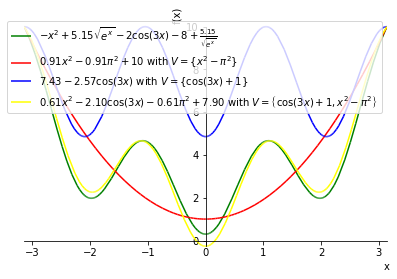

In [23]:


#choice of approach functions
v0 = parse_expr("x**2 - pi**2")
v1 = parse_expr("cos(3*x)+1")
v2 = parse_expr("x")
v3 = parse_expr("x**2-x")
v4 = parse_expr("cos(2*x)-1")
v5 = parse_expr("x-5")
v6 = parse_expr("x")
v7 = parse_expr("x**3")
V0 = [v0]
V = [v1]
V1 = [v1,v0]
V2 = [v2]
V3 = [v2,v3]
V4 = [v2,v3,v7]


plt.figure(figsize=(18,5))

#find exact solution
u = Function('u')
x = Symbol('x')
real_sol = exact(a2*u(x).diff(x,2)+a1*u(x).diff(x,1) + a0*u(x)-f, x0,y0,p0,x1,y1,p1,a2)
print(real_sol)
pr = plot(real_sol, (x,x0,x1),show = False, line_color = 'green', legend = True)
pr[0].label = "$"+latex(pretty_label(real_sol))+"$"

f_1,p_1 = ritz_galerkin(a1,a0,x0,y0,p0,x1,y1,p1,f,V0,a2=a2)
f_2,p_2 = ritz_galerkin(a1,a0,x0,y0,p0,x1,y1,p1,f,V,col ='blue',a2=a2)
f_3,p_3 = ritz_galerkin(a1,a0,x0,y0,p0,x1,y1,p1,f,V1,col ='yellow',a2=a2)

pr.append(p_1[0])
pr.append(p_2[0]) 
pr.append(p_3[0])

pr.show() # show plot with everything inside


In [6]:
#Backup
#inhomogeneous part
f = parse_expr("5+8*x - 2*x**2")
#Lu = a2*u'' + a1*u' + a0*u, (a2 = 1)
a2 = 1
a1 = 2
a0 = -1
#boundary conditions: False - on u; True - on u'
x0 = 0
y0 = -1
p0 = False
x1 = 1
y1 = 1
p1 = False